In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

path = '/home/hiram/Documentos/Congresos/MexiCOPAS/MACSS2017/Projects/supernova/'

In [2]:
def E(z,OmDE):
    return 1/np.sqrt((1.-OmDE)*(1.+z)**3.+OmDE)

def dl(z, OmDE, h=0.7):
    inte = integrate.quad(E,0,z,args=(OmDE))
    c = 299792.458 #Speed of light in km/s
    H0 = 100*h #Hubble parameter
    return c*(1.+z)/H0 * inte[0]

In [3]:
zandmu = np.loadtxt(path+'SCPUnion2.1_mu_vs_z.txt', usecols =(1,2))
covariance = np.loadtxt(path+'SCPUnion2.1_covmat_sys.txt')

In [4]:
dl = np.vectorize(dl)

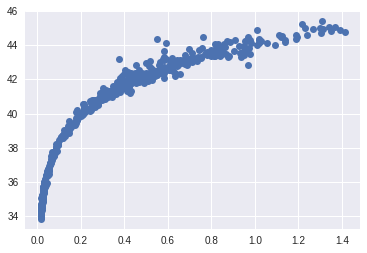

In [5]:
plt.plot(zandmu[:,0],zandmu[:,1],'o')

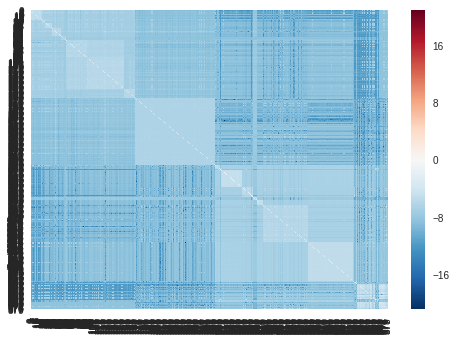

In [6]:
sb.set()
newmatrix = np.log(np.abs(covariance))
sb.heatmap(newmatrix)

In [7]:
def loglike(params,h=0.7):
    OmDE = params[0]
    delta = 5.*np.log10(dl(zandmu[:,0],OmDE,h))+25. - zandmu[:,1]
    chisquare = np.dot(delta,np.dot(np.linalg.inv(covariance),delta))
    return -chisquare/2.

In [8]:
table_omega = np.arange(0.,1.,0.01)
tableprob = [loglike([omde]) for omde in table_omega]

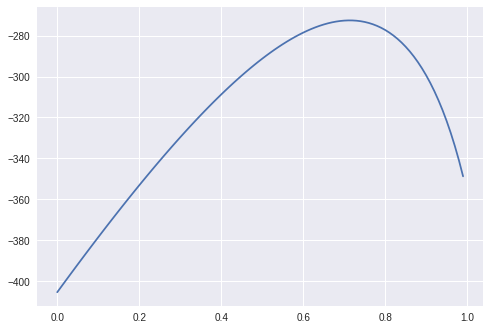

In [9]:
plt.plot(table_omega,tableprob)

In [10]:
paramspath = '/home/hiram//Documentos/Congresos/MexiCOPAS/MACSS2017/Projects/supernova/jla_likelihood_v6/data/'
jla_dataset = np.genfromtxt(paramspath+'jla_lcparams.txt', names=True, dtype=None)

In [11]:
jla_dataset['zcmb']

array([ 0.503084,  0.580724,  0.494795,  0.345928,  0.677662,  0.610712,
        0.866494,  0.330932,  0.798566,  0.449562,  0.371443,  0.291718,
        0.35582 ,  0.461274,  0.28361 ,  0.632234,  0.466414,  0.268624,
        0.94689 ,  0.924917,  0.693165,  0.625233,  0.896944,  0.608261,
        0.789054,  0.578292,  0.59028 ,  0.719626,  0.210032,  0.76659 ,
        0.858513,  0.367904,  0.558746,  0.848509,  0.99639 ,  0.776594,
        0.582932,  0.583743,  0.796552,  0.588721,  0.913473,  0.768587,
        0.948455,  0.513793,  0.733609,  0.637701,  0.765588,  0.434861,
        0.983407,  0.583743,  0.700631,  0.662058,  0.838126,  0.621874,
        0.370586,  0.416632,  0.35857 ,  0.451681,  0.522762,  0.733996,
        0.701965,  0.742008,  0.746118,  0.34956 ,  0.591835,  0.514746,
        0.620632,  0.643646,  1.002795,  0.470586,  0.610643,  0.263487,
        0.358336,  0.742697,  0.451556,  0.910752,  0.552605,  0.337534,
        0.750681,  0.983777,  0.822697,  0.813696, 

In [12]:
jla_dataset.dtype.names

('name',
 'zcmb',
 'zhel',
 'dz',
 'mb',
 'dmb',
 'x1',
 'dx1',
 'color',
 'dcolor',
 '3rdvar',
 'd3rdvar',
 'tmax',
 'dtmax',
 'cov_m_s',
 'cov_m_c',
 'cov_s_c',
 'set',
 'ra',
 'dec',
 'biascor')

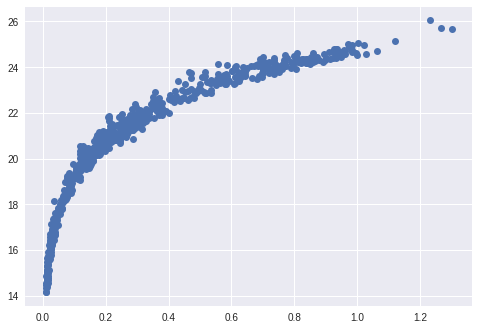

In [13]:
plt.plot(jla_dataset['zcmb'],jla_dataset['mb'],'o')

In [14]:
import pyfits
import glob

covmatpath = '/home/hiram//Documentos/Congresos/MexiCOPAS/MACSS2017/Projects/supernova/covmat/'
def mu_cov(alpha, beta):
    """ Assemble the full covariance matrix of distance modulus

    See Betoule et al. (2014), Eq. 11-13 for reference
    """
    Ceta = sum([pyfits.getdata(mat) for mat in glob.glob(covmatpath+'C*.fits')])

    Cmu = np.zeros_like(Ceta[::3,::3])
    for i, coef1 in enumerate([1., alpha, -beta]):
        for j, coef2 in enumerate([1., alpha, -beta]):
            Cmu += (coef1 * coef2) * Ceta[i::3,j::3]

    # Add diagonal term from Eq. 13
    sigma = np.loadtxt(covmatpath+'sigma_mu.txt')
    sigma_pecvel = (5 * 150 / 3e5) / (np.log(10.) * sigma[:, 2])
    Cmu[np.diag_indices_from(Cmu)] += sigma[:, 0] ** 2 + sigma[:, 1] ** 2 + sigma_pecvel ** 2
    
    return Cmu

In [15]:
Cmu = mu_cov(0.13, 3.1)

In [16]:
np.shape(Cmu)

(740, 740)

In [17]:
 def loglike_jla(params,h=0.7):
    """
    This function computes the logarithm of the likelihood. It recieves a vector
    params-> vector with three components (Omega Dark Energy, alpha, beta and M_b)
    """
    OmDE = params[0]
    alpha = params[1]
    beta = params[2]
    MB = params[3]
    covariance = mu_cov(alpha, beta)
    inv_covariance=np.linalg.inv(covariance)
# Ahora quiero calcular la diferencia entre el valor reportado y el calculado
    mu_obs = jla_dataset['mb']-(MB-alpha*jla_dataset['x1']+beta*jla_dataset['color'])
    mu_teo = 5.*np.log10(dl(jla_dataset['zcmb'],OmDE,h))+25
    delta = mu_teo - mu_obs
    chisquare = np.dot(delta,np.dot(inv_covariance,delta))
    return -chisquare/2

In [18]:
param = [0.65,0.13,3.1,-20]
loglike_jla(param)

-2343.1642968305641

In [19]:
param = [0.7,0.13,3.1,-19]
loglike_jla(param)

-358.18533951434915

In [20]:
start_point=[0.5,0.1,0.3,-20.]
chain = [start_point]
likelihood_chain = [loglike(start_point)]
step_width = [0.07,0.1,0.1,0.1]
number_of_steps=10
accepted = 0

In [21]:
for i in range(number_of_steps):
    #Generate a random number starting at current point
    rand = np.random.normal(0.,1.,4)
    newpoint = chain[i] + step_width*rand
     #Compute the loglike in the new point
    liketry = loglike_jla(newpoint)
    #Now the probability of acceptance
    if liketry >likelihood_chain[i]:
        prob_acceptance = 1
    else:
        prob_accept = np.exp(liketry - likelihood_chain[i])
        
    #Now compare that probability to a random number between 0 and 1
    if prob_accept >= np.random.uniform(0.1,1.):
        chain.append(newpoint)
        likelihood_chain.append(liketry)
        accepted += 1
    else: 
        chain.append(chain[i])
        likelihood_chain.append(likelihood_chain[i])
        
print 'Razon de aceptacion =', float(accepted)/float(number_of_steps)

Razon de aceptacion = 0.0


In [22]:
chain = np.array(chain)
omega_chain = chain[:,0]
average = np.mean(omega_chain)
print average

0.5


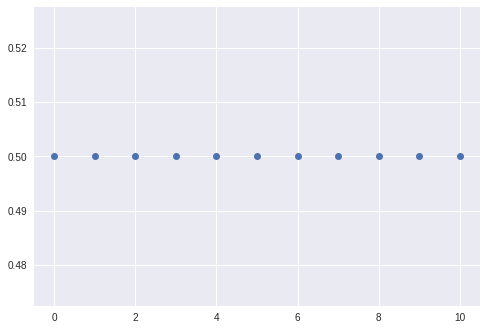

In [23]:
plt.plot(omega_chain,'o')